In [ ]:
!pip install torch
!pip install magent2
!pip install opencv-python
!pip install tqdm

In [58]:
# import lib
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from magent2.environments import battle_v4
import copy
import faulthandler
import math
import matplotlib.pyplot as plt
faulthandler.enable()

## Training agents

In [59]:
# My QNetwork, adding GRU and LayerNorm to learn sequental and skip exploit and vanishing gradient

class QNetworkGRU(nn.Module):
    def __init__(self, observation_shape, action_shape,hidden_size=256,num_layers=2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.gru = nn.GRU(input_size=flatten_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=False)

        self.network = nn.Sequential(
            nn.Linear(hidden_size, 120),
            nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.LayerNorm(84),
            nn.Tanh(),
        )

        self.last_layer = nn.Linear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = x.unsqueeze(0)
        out, hidden = self.gru(x)
        x = out[-1, :, :]
        
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)


In [60]:
# Use SumTree to build Priotized Replay Buffer, which sort prioritize the samples by td-error
 
class SumTree:
    """
    A binary tree data structure where the parent's value is the sum of its children
    Used in Prioritized Experience Replay
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0
        self.is_full = False

    def add(self, priority, data):
        """Add new entry to the tree"""
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_idx, priority)
        
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0
            self.is_full = True

    def update(self, tree_idx, priority):
        """Update the priority of an existing entry"""
        # Ensure non-negative priority
        priority = max(priority, 1e-8)
        
        change = priority - self.tree[tree_idx]
        self.tree[tree_idx] = priority

        # Propagate the change upwards
        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v):
        """
        Get a leaf from the tree based on the given value
        Returns: tree index, priority, data
        """
        parent_idx = 0
        while True:
            left_child_idx = 2 * parent_idx + 1
            right_child_idx = left_child_idx + 1

            # If we reach bottom of the tree
            if left_child_idx >= len(self.tree):
                leaf_idx = parent_idx
                break

            # Determine which child to follow
            if v <= self.tree[left_child_idx]:
                parent_idx = left_child_idx
            else:
                v -= self.tree[left_child_idx]
                parent_idx = right_child_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    def total_priority(self):
        """Return the total priority in the tree"""
        return self.tree[0]

In [61]:
class PrioritizedReplayBuffer:
    """Prioritized Replay Buffer with proportional prioritization"""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment_per_sampling=0.001, max_priority=1.0):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.alpha = alpha  # How much prioritization is used
        self.beta = beta    # Initial importance sampling weight
        self.beta_increment_per_sampling = beta_increment_per_sampling
        self.max_priority = max_priority
        self.epsilon = 1e-8  # Small amount to avoid zero priority

    def push(self, state, action, reward, next_state, done):
        # Always insert with max priority to ensure it gets sampled
        priority = self.max_priority
        
        # Ensure state, next_state are not None
        if state is None or (next_state is None and not done):
            return

        # Store the experience
        experience = (state, action, reward, next_state, done)
        self.tree.add(priority, experience)

    def sample(self, batch_size):
        # Increment beta
        self.beta = min(1.0, self.beta + self.beta_increment_per_sampling)

        # Ensure we have enough samples
        if self.tree.is_full:
            total_samples = self.capacity
        else:
            total_samples = self.tree.data_pointer

        if total_samples < batch_size:
            raise ValueError(f"Not enough samples. Required: {batch_size}, Available: {total_samples}")

        # Create batch arrays
        batch_idx = np.zeros(batch_size, dtype=np.int32)
        batch_states = []
        batch_actions = []
        batch_rewards = []
        batch_next_states = []
        batch_dones = []
        batch_weights = np.zeros(batch_size, dtype=np.float32)

        # Get total priority and segment size
        total_priority = self.tree.total_priority()
        segment = total_priority / batch_size
        priorities = []

        for i in range(batch_size):
            # Ensure sampling is within range
            a = segment * i
            b = segment * (i + 1)

            # Clip sampling value to avoid overflow
            v = np.random.uniform(max(0, a), min(total_priority, b))
            
            # Get the corresponding leaf
            idx, p, data = self.tree.get_leaf(v)
            
            # Store sampling info
            batch_idx[i] = idx
            batch_states.append(data[0])
            batch_actions.append(data[1])
            batch_rewards.append(data[2])
            batch_next_states.append(data[3])
            batch_dones.append(data[4])
            priorities.append(p)

        # Convert to tensors
        batch_states = torch.tensor(np.array(batch_states), dtype=torch.float32).permute(0, 3, 1, 2)
        batch_actions = torch.tensor(batch_actions, dtype=torch.long)
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32)
        
        # Handle potential None next_states
        batch_next_states = torch.tensor(
            np.array([ns if ns is not None else np.zeros_like(batch_states[0].numpy()) for ns in batch_next_states]), 
            dtype=torch.float32
        ).permute(0, 3, 1, 2)
        
        batch_dones = torch.tensor(batch_dones, dtype=torch.float32)

        # Importance sampling weights
        priorities = np.array(priorities)
        sampling_probs = priorities / total_priority
        weights = (len(self.tree.data) * sampling_probs) ** -self.beta
        weights /= weights.max()
        batch_weights = torch.tensor(weights, dtype=torch.float32)

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, batch_idx, batch_weights

    def update_priorities(self, batch_indices, batch_priorities):
        """
        Update priorities of sampled experiences
        Add small epsilon to avoid zero priorities
        """
        for idx, priority in zip(batch_indices, batch_priorities):
            # Ensure priority is not too small
            priority = np.power(np.abs(priority) + self.epsilon, self.alpha)
            self.tree.update(idx, priority)

    def __len__(self):
        """Return the current size of the replay buffer."""
        return self.tree.data_pointer

In [62]:
# Using soft update
def soft_update(target_network, online_network, tau=0.01):
    for target_param, online_param in zip(target_network.parameters(), online_network.parameters()):
        target_param.data.copy_(tau * online_param.data + (1 - tau) * target_param.data)

In [63]:
# Use episilon-greedy policy
def get_action(env,obs_tensor,q_network,epsilon,agent):
    if random.random() < epsilon:
        action = env.action_space(agent).sample()
    else:
        with torch.no_grad():
            q_values = q_network(obs_tensor)
            action = q_values.argmax().item()

In [64]:
# Training agent with cross_ratio,
# 1: full crossQ, 0: fullDQN
def train(q_network, q_network_cross, target_network, 
          replay_buffer, optimizer, gamma, batch_size, cross_ratio=0.8):
    
    # Sample from prioritized replay buffer
    states, actions, rewards, next_states, dones, batch_indices, weights = replay_buffer.sample(batch_size)
    
    # Move to device
    states = states.to(device)
    actions = actions.to(device).long()  # Ensure actions are of long type
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)
    weights = weights.to(device)

    # Compute current Q values
    q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        # Choose next actions based on cross or own Q-network
        if random.random() < cross_ratio:
            next_actions = q_network_cross(next_states).argmax(1)
        else:
            next_actions = q_network(next_states).argmax(1)
        
        # Compute next Q values using target network
        next_q_values = target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
    
    # Compute target values
    target_values = rewards + gamma * next_q_values * (1 - dones)

    # Compute TD error (difference between predicted and target Q values)
    td_errors = torch.abs(q_values - target_values)

    # Compute weighted MSE loss
    loss = F.mse_loss(q_values, target_values, reduction='none')  # MSE loss without reduction
    loss = (loss * weights).mean()  # Apply weights and compute the mean loss

    # Update priorities in the replay buffer
    replay_buffer.update_priorities(batch_indices, td_errors.cpu().detach().numpy())

    # Optimize the model
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Backpropagate gradients
    optimizer.step()       # Update parameters based on gradients

    return loss.item()  # Return the loss value

In [65]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [66]:
# Set up Hyperparameters
episodes = 20
max_steps = 300
buffer_capacity = 10000
batch_size = 1024
gamma = 0.99
learning_rate = 1e-4
update_target_steps = 10
tau = 0.1   # Soft update parameter
epsilon_min = 0.1
epsilon_decay = 0.1 ** (1 / episodes)

In [67]:
# Init env
# Environment setup
parallel_env = battle_v4.parallel_env(
    map_size=45,
    minimap_mode=False,
    step_reward=-0.005,
    dead_penalty=-0.1,
    attack_penalty=-0.05,
    attack_opponent_reward=0.4,
    extra_features=False,
    max_cycles=max_steps,
)

In [68]:
# Set up space for training
example_agent = list(parallel_env.agents)[0]
obs_space = parallel_env.observation_space(example_agent).shape
action_space = parallel_env.action_space(example_agent).n

# Q-networks for blue and red teams
q_network_blue = QNetworkGRU(obs_space, action_space).to(device)
target_network_blue = QNetworkGRU(obs_space, action_space).to(device)
target_network_blue.load_state_dict(q_network_blue.state_dict())
target_network_blue.eval()

q_network_red = QNetworkGRU(obs_space, action_space).to(device)
target_network_red = QNetworkGRU(obs_space, action_space).to(device)
target_network_red.load_state_dict(q_network_red.state_dict())
target_network_red.eval()

# Optimizers for both teams
optimizer_blue = optim.Adam(q_network_blue.parameters(), lr=learning_rate)
optimizer_red = optim.Adam(q_network_red.parameters(), lr=learning_rate)

# Prioritized Replay Buffers for both teams
replay_buffer_blue = PrioritizedReplayBuffer(buffer_capacity)
replay_buffer_red = PrioritizedReplayBuffer(buffer_capacity)

In [71]:

blue_rewards_history = []
red_rewards_history = []
avg_loss_blue_history = []
avg_loss_red_history = []
epsilon_history = []


def plot_results(blue_rewards, red_rewards, blue_losses, red_losses, epsilon_history):
    # Vẽ Reward theo các episode
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(blue_rewards, label='Blue Agent Rewards')
    plt.plot(red_rewards, label='Red Agent Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # Vẽ Loss trung bình theo các episode
    plt.subplot(2, 2, 2)
    plt.plot(blue_losses, label='Blue Agent Loss')
    plt.plot(red_losses, label='Red Agent Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ Epsilon decay
    plt.subplot(2, 2, 3)
    plt.plot(epsilon_history, label='Epsilon')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [72]:
# Training phase
for episode in tqdm(range(episodes)):
    observations = parallel_env.reset()
    agent_rewards = {agent: 0 for agent in parallel_env.agents}
    total_loss_blue, total_loss_red = 0.0, 0.0

    # Improved Exponential Epsilon Decay
    epsilon = max(epsilon_min, epsilon_decay ** episode)

    for step in range(max_steps):
        actions = {}
        for agent, obs in observations.items():
            obs_tensor = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
            # Select action based on team
            if "blue" in agent:
                if random.random() < epsilon:
                    action = parallel_env.action_space(agent).sample()
                else:
                    with torch.no_grad():
                        q_values = q_network_blue(obs_tensor)
                        action = q_values.argmax().item()
            elif "red" in agent:
                if random.random() < epsilon:
                    action = parallel_env.action_space(agent).sample()
                else:
                    with torch.no_grad():
                        q_values = q_network_red(obs_tensor)
                        action = q_values.argmax().item()

            actions[agent] = action

        next_observations, rewards, terminations, truncations, _ = parallel_env.step(actions)
        for agent in parallel_env.agents:
            next_state = next_observations[agent] if not (terminations[agent] or truncations[agent]) else None
            dones = True if (terminations[agent] or truncations[agent]) else False

            if "blue" in agent:
                replay_buffer_blue.push(
                    observations[agent],
                    actions[agent],
                    rewards[agent],
                    next_state,
                    dones,
                )
            else:
                replay_buffer_red.push(
                    observations[agent],
                    actions[agent],
                    rewards[agent],
                    next_state,
                    dones,
                )
            agent_rewards[agent] += rewards[agent]

        if (len(replay_buffer_red) >= batch_size and len(replay_buffer_blue) >= batch_size):
            # Train blue agents
            loss_blue = train(q_network_blue, q_network_red, target_network_blue, 
                                replay_buffer_blue, optimizer_blue, gamma,batch_size,cross_ratio=0.8)
            # Train red agents
            loss_red = train(q_network_red, q_network_blue, target_network_red, 
                                replay_buffer_red, optimizer_red, gamma,batch_size,cross_ratio=0)                

            total_loss_blue += loss_blue
            total_loss_red += loss_red

        if step % update_target_steps == 0:
            soft_update(target_network_red, q_network_red, tau)
            soft_update(target_network_blue, q_network_blue, tau)

        observations = copy.deepcopy(next_observations)
        # print(f"For step: {step}, Number of agent: {parallel_env.num_agents}")
        if(parallel_env.num_agents == 0): break

    blue_rewards = sum(reward for agent, reward in agent_rewards.items() if "blue" in agent)
    red_rewards = sum(reward for agent, reward in agent_rewards.items() if "red" in agent)
    avg_loss_blue = total_loss_blue / max_steps if len(replay_buffer_blue.tree.data) >= batch_size else 0
    avg_loss_red = total_loss_red / max_steps if len(replay_buffer_red.tree.data) >= batch_size else 0

    blue_rewards_history.append(blue_rewards)
    red_rewards_history.append(red_rewards)
    avg_loss_blue_history.append(avg_loss_blue)
    avg_loss_red_history.append(avg_loss_red)
    epsilon_history.append(epsilon)

    print(f"Episode {episode + 1}/{episodes}, Blue Reward: {blue_rewards}, Red Reward: {red_rewards}, "
            f"Blue Loss: {avg_loss_blue:.4f}, Red Loss: {avg_loss_red:.4f}, Epsilon: {epsilon:.2f}")

parallel_env.close()
torch.save(q_network_blue.state_dict(), 'blue_agent_final.pt')
torch.save(q_network_red.state_dict(), 'red_agent_final.pt')
print("Training completed and models saved!")

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:51<16:19, 51.55s/it]

Episode 1/20, Blue Reward: -520.2449960932136, Red Reward: -522.1749958060682, Blue Loss: 0.0001, Red Loss: 0.0002, Epsilon: 1.00


 10%|█         | 2/20 [01:45<15:48, 52.71s/it]

Episode 2/20, Blue Reward: -259.20999809447676, Red Reward: -37.120015405118465, Blue Loss: 0.0002, Red Loss: 0.0022, Epsilon: 0.89


 15%|█▌        | 3/20 [02:42<15:29, 54.66s/it]

Episode 3/20, Blue Reward: -99.67000090330839, Red Reward: 83.43997886311263, Blue Loss: 0.0006, Red Loss: 0.0046, Epsilon: 0.79


 20%|██        | 4/20 [03:43<15:19, 57.45s/it]

Episode 4/20, Blue Reward: 67.54499386716634, Red Reward: 175.88997874315828, Blue Loss: 0.0018, Red Loss: 0.0057, Epsilon: 0.71


 25%|██▌       | 5/20 [04:38<14:09, 56.61s/it]

Episode 5/20, Blue Reward: 188.68498865049332, Red Reward: 258.0099777895957, Blue Loss: 0.0029, Red Loss: 0.0063, Epsilon: 0.63


 30%|███       | 6/20 [05:13<11:27, 49.08s/it]

Episode 6/20, Blue Reward: 172.46499006450176, Red Reward: 332.1249769059941, Blue Loss: 0.0022, Red Loss: 0.0032, Epsilon: 0.56


 35%|███▌      | 7/20 [06:09<11:09, 51.49s/it]

Episode 7/20, Blue Reward: 224.58498707506806, Red Reward: 271.9149785414338, Blue Loss: 0.0046, Red Loss: 0.0079, Epsilon: 0.50


 40%|████      | 8/20 [07:07<10:41, 53.46s/it]

Episode 8/20, Blue Reward: 348.9099769797176, Red Reward: 302.8899828242138, Blue Loss: 0.0074, Red Loss: 0.0062, Epsilon: 0.45


 45%|████▌     | 9/20 [07:30<08:01, 43.81s/it]

Episode 9/20, Blue Reward: 248.31998737249523, Red Reward: 436.09997620340437, Blue Loss: 0.0019, Red Loss: 0.0033, Epsilon: 0.40


 50%|█████     | 10/20 [08:06<06:55, 41.53s/it]

Episode 10/20, Blue Reward: 298.28498519118875, Red Reward: 433.20497606601566, Blue Loss: 0.0048, Red Loss: 0.0110, Epsilon: 0.35


 55%|█████▌    | 11/20 [08:23<05:06, 34.08s/it]

Episode 11/20, Blue Reward: 362.7949819881469, Red Reward: 460.56997622922063, Blue Loss: 0.0030, Red Loss: 0.0041, Epsilon: 0.32


 60%|██████    | 12/20 [08:45<04:03, 30.45s/it]

Episode 12/20, Blue Reward: 462.52997575327754, Red Reward: 343.2249831967056, Blue Loss: 0.0055, Red Loss: 0.0057, Epsilon: 0.28


 65%|██████▌   | 13/20 [09:40<04:24, 37.85s/it]

Episode 13/20, Blue Reward: 341.99498298112303, Red Reward: 358.43997793644667, Blue Loss: 0.0161, Red Loss: 0.0201, Epsilon: 0.25


 70%|███████   | 14/20 [10:04<03:20, 33.49s/it]

Episode 14/20, Blue Reward: 406.73998035117984, Red Reward: 473.9349756119773, Blue Loss: 0.0058, Red Loss: 0.0061, Epsilon: 0.22


 75%|███████▌  | 15/20 [10:23<02:25, 29.16s/it]

Episode 15/20, Blue Reward: 416.75997975002974, Red Reward: 477.46497560385615, Blue Loss: 0.0050, Red Loss: 0.0053, Epsilon: 0.20


 80%|████████  | 16/20 [10:38<01:39, 24.83s/it]

Episode 16/20, Blue Reward: 317.4349849484861, Red Reward: 479.92997585237026, Blue Loss: 0.0046, Red Loss: 0.0060, Epsilon: 0.18


 85%|████████▌ | 17/20 [11:10<01:21, 27.13s/it]

Episode 17/20, Blue Reward: 427.4499794105068, Red Reward: 468.5149762518704, Blue Loss: 0.0133, Red Loss: 0.0234, Epsilon: 0.16


 90%|█████████ | 18/20 [11:22<00:44, 22.44s/it]

Episode 18/20, Blue Reward: 407.3549803206697, Red Reward: 475.4149760901928, Blue Loss: 0.0030, Red Loss: 0.0039, Epsilon: 0.14


 95%|█████████▌| 19/20 [11:54<00:25, 25.53s/it]

Episode 19/20, Blue Reward: 431.34997909422964, Red Reward: 459.81497623585165, Blue Loss: 0.0154, Red Loss: 0.0203, Epsilon: 0.13


100%|██████████| 20/20 [12:10<00:00, 36.51s/it]

Episode 20/20, Blue Reward: 324.3999851802364, Red Reward: 478.9349763710052, Blue Loss: 0.0048, Red Loss: 0.0057, Epsilon: 0.11
Training completed and models saved!


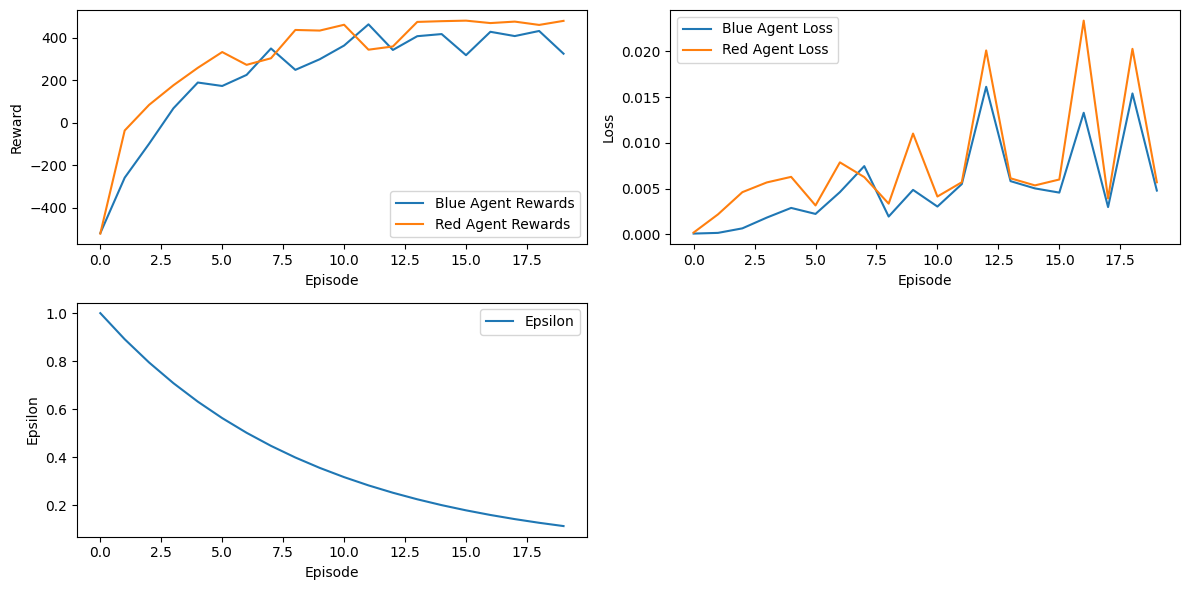

In [73]:
plot_results(blue_rewards_history, red_rewards_history, avg_loss_blue_history, avg_loss_red_history, epsilon_history)

## Evaluation with teacher model

In [74]:
# Teacher model
class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

# Final Network
class FinalQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            # nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            # nn.LayerNorm(84),
            nn.Tanh(),
        )
        self.last_layer = nn.Linear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)

In [75]:
from magent2.environments import battle_v4
import torch
import numpy as np
import torch.nn as nn

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # Fallback: tqdm becomes a no-op



def eval():
    max_cycles = 300
    env = battle_v4.env(map_size=45, max_cycles=max_cycles)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def random_policy(env, agent, obs):
        return env.action_space(agent).sample()

    # middle red policy
    q_network = QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    q_network.load_state_dict(
        torch.load("red.pt", weights_only=True, map_location="cpu")
    )
    q_network.to(device)
    # final red policy
    final_q_network = FinalQNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    final_q_network.load_state_dict(
        torch.load("red_final.pt", weights_only=True, map_location="cpu")
    )
    final_q_network.to(device)

    q_network_blue = QNetworkGRU(
        env.observation_space("blue_0").shape, env.action_space("blue_0").n
    )
    # My blue policy
    q_network_blue.load_state_dict(
        torch.load("blue_agent_final.pt", weights_only=True, map_location="cpu")
    )
    q_network_blue.to(device)

    def blue_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = q_network_blue(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]


    def pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def final_pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = final_q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
        red_win, blue_win = [], []
        red_tot_rw, blue_tot_rw = [], []
        n_agent_each_team = len(env.env.action_spaces) // 2

        for _ in tqdm(range(n_episode)):
            env.reset()
            n_kill = {"red": 0, "blue": 0}
            red_reward, blue_reward = 0, 0

            for agent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                agent_team = agent.split("_")[0]

                n_kill[agent_team] += (
                    reward > 4.5
                )  # This assumes default reward settups
                if agent_team == "red":
                    red_reward += reward
                else:
                    blue_reward += reward

                if termination or truncation:
                    action = None  # this agent has died
                else:
                    if agent_team == "red":
                        action = red_policy(env, agent, observation)
                    else:
                        action = blue_policy(env, agent, observation)

                env.step(action)

            who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
            who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
            red_win.append(who_wins == "red")
            blue_win.append(who_wins == "blue")

            red_tot_rw.append(red_reward / n_agent_each_team)
            blue_tot_rw.append(blue_reward / n_agent_each_team)

        return {
            "winrate_red": np.mean(red_win),
            "winrate_blue": np.mean(blue_win),
            "average_rewards_red": np.mean(red_tot_rw),
            "average_rewards_blue": np.mean(blue_tot_rw),
        }

    print("=" * 20)
    print("Eval with random policy")
    print(
        run_eval(
            env=env, red_policy=random_policy, blue_policy=blue_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with trained policy")
    print(
        run_eval(
            env=env, red_policy=pretrain_policy, blue_policy=blue_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with final trained policy")
    print(
        run_eval(
            env=env,
            red_policy=final_pretrain_policy,
            blue_policy=blue_policy,
            n_episode=30,
        )
    )
    print("=" * 20)


if __name__ == "__main__":
    eval()

/work/hpc/miniconda3/envs/rl-env/lib/python3.10/site-packages/pettingzoo/utils/wrappers/base.py:64: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.


Eval with random policy


100%|██████████| 30/30 [06:21<00:00, 12.70s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -1.1615555974923135, 'average_rewards_blue': 0.7363928112163068}
Eval with trained policy


100%|██████████| 30/30 [03:56<00:00,  7.87s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 0.8969485528111732, 'average_rewards_blue': 4.073403225278429}
Eval with final trained policy


100%|██████████| 30/30 [05:30<00:00, 11.00s/it]

{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 2.224820971614662, 'average_rewards_blue': 3.3257118429114794}
